In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [22]:
class Simulation:
    def __init__(self, A, initial_state, whatH):
        self.A = A
        self.initial_state = initial_state
        self.whatH = whatH
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega = sc.optimal_omegad(self.A)[0]*2*np.pi

        if self.whatH == 'H2':
            # Setup actual system
            self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 

    def H2(self):
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        # Create H_control with only specific off-diagonal elements
        H_control = self.sc.H_control.copy()
        # Zero out all elements first
        H_control[:] = 0

        # Keep only elements [0,2], [1,3], [2,4], [3,5] and their symmetric counterparts
        for i in range(len(H_control) - 2):
            # Keep the upper diagonal elements [i, i+2]
            H_control[i, i+2] = self.sc.H_control[i, i+2]
            # Make it symmetric by setting [i+2, i]
            H_control[i+2, i] = self.sc.H_control[i+2, i]

        H0 = qt.Qobj(H0) 
        H_control = qt.Qobj(H_control)
        H_rot = self.optimal_omega*np.kron(np.array([[0,0,0],[0,1,0],[0,0,2]]), np.identity(2)) + self.optimal_omega*np.kron(np.identity(3), np.array([[0,0],[0,1]])) 

        # H_rot = H0 + A/2*H_control
        H0_rot = H0.full() - H_rot+ self.A/2 * H_control.full()
        evals_rot, U = np.linalg.eigh(H0_rot)
        evals_rot, U = sort_eigenpairs(evals_rot, U)
        evals_rot = evals_rot - evals_rot[0]
        self.omega_c = evals_rot[1]
        Ud = U.T.conj()
        U = qt.Qobj(U)
        Ud = qt.Qobj(Ud)
        dressed00 = qt.Qobj(U[:,0])
        dressed01 = qt.Qobj(U[:,1])
        dressed10 = qt.Qobj(U[:,2])
        dressed11 = qt.Qobj(U[:,3])
        P10 = dressed10 * dressed10.dag()
        P11 = dressed11 * dressed11.dag()
        P00 = dressed00 * dressed00.dag()
        P01 = dressed01 * dressed01.dag()
        sigmaxc = np.kron(np.identity(3), np.array([[0,1],[1,0]]))
        sigmaxs = np.kron(np.array([[0,1,0],[1,0,0],[0,0,0]]), np.identity(2))
        sigmaxc = U@sigmaxc@Ud
        sigmaxs = U@sigmaxs@Ud
        initial00 = dressed00
        initial01 = dressed01
        initialpc = np.sqrt(1/2)*(dressed00 + dressed01)
        initialps = np.sqrt(1/2)*(dressed00 + dressed10)
        print(Ud@self.sc.noise@U)
        noise = np.diag(np.diag(self.sc.noise) - np.diag(self.sc.noise)[0])
        self.noise = qt.Qobj(noise)
        self.s = np.zeros([6,6], dtype=complex)
        self.s[:4,:4] = self.sc.s[:4,:4]
        if self.initial_state == '00':
            initial_state = initial00
            M = P10
        elif self.initial_state == '01':
            initial_state = initial01
            M = [P00,P01,P10,P11]
        elif self.initial_state == 'pc':
            initial_state = initialpc
            M = sigmaxc
        elif self.initial_state == 'ps':
            initial_state = initialps
            M = sigmaxs
        
        return qt.Qobj(H0.full()-H_rot), H_control , initial_state, M, self.noise
  
    def gaussian_ramp(self, t_rise, t_flat, t_down, amplitude):
        """
        Creates a time-dependent function using a Gaussian function that rises, 
        stays flat, and then falls.

        Args:
        t_rise (float): The time at which the function reaches the amplitude.
        t_flat (float): The duration for which the function stays at the amplitude.
        t_down (float): The time it takes for the function to fall back to zero.
        amplitude (float): The maximum amplitude of the Gaussian peak.

        Returns:
        function: A function of time 't' that implements the desired behavior.
        """
        # Define the standard deviation for the Gaussian edges
        sigma_rise = t_rise / 3  # Adjust sigma to make the function start close to zero at t=0
        sigma_down = t_down / 3  # Similar adjustment for the falling edge

        # Define the function using a closure to encapsulate the parameters
        def time_dependent_function(t):
            t_start_flat = t_rise  # Time when flat region starts
            t_end_flat = t_rise + t_flat  # Time when flat region ends
            
            if t <= t_start_flat:
                # Gaussian rise centered at t_rise
                return amplitude * np.exp(-((t - t_start_flat)**2) / (2 * sigma_rise**2)) - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))
            elif t >= t_end_flat:
                # Gaussian fall centered at t_end_flat
                return amplitude * np.exp(-((t - t_end_flat)**2) / (2 * sigma_down**2)) - amplitude * np.exp(-((t_end_flat + t_down - t_end_flat)**2) / (2 * sigma_down**2))
            else:
                # Constant amplitude in the middle region
                return amplitude - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))

        return time_dependent_function
    
    def analyze_and_fit_decay(self, simulation, time_points, avg_value, S0, ifplot=True):
        from scipy.optimize import curve_fit
        # Setup time points
        t_max = time_points[-1]
        N = t_max
        if simulation.initial_state == '00' or simulation.initial_state == '01':
            # Define exponential decay function with fixed offset of 1/2
            def exp_decay_fixed_offset(t, T):
                return 0.5 * (1 - np.exp(-t / T))
        elif simulation.initial_state == 'pc': 
            def exp_decay_fixed_offset(t, T):
                return np.exp(-t / T) * np.cos(simulation.omega_c * t)

        # Fit the data with exponential decay (fixed offset = 1/2)
        params, pcov = curve_fit(exp_decay_fixed_offset, time_points, avg_value, p0=[1000])
        T_fit = params[0]

        if ifplot:
            # Plot the results with the fit
            plt.figure(figsize=(5, 3))
            # std_value = np.std(result, axis=0)
            # plt.errorbar(time_points, avg_value, yerr=std_value, fmt='b-', label='Simulation data', capsize=3)
            plt.plot(time_points, avg_value, 'b-', label='Simulation data')
            plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
                        label=f'Fit: 0.5*(1+exp(-t/T)), T = {T_fit:.2f} ns')
            plt.xlabel('Time (ns)')
            plt.ylabel('Population')
            plt.title('Population dynamics with exponential fit (fixed offset = 1/2)')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Print the fitted parameters
        if ifplot:
            print(f"Fitted T = {T_fit:.4f} ns")
        sc = simulation.sc
        S0P = S0 * (sc.omega_s_per - sc.omega_s) / 1e-6
        optimal_omega = simulation.optimal_omega
        sc = Hamiltonian(sc.phi_ex, sc.Ej, sc.Ec, [2,1])
        H0, H_control, initial_state, M, noise = simulation.H2()
        evals_rot, U = np.linalg.eigh((H0 + simulation.A/2*H_control).full())
        evals_rot, U = sort_eigenpairs(evals_rot, U)
        Ud = U.T.conj()
        me = (Ud@noise.full()@U)[0,2]
        detu = (evals_rot[2]-evals_rot[0])/2/np.pi
        rate = S0**2 / (detu) * (np.abs(me)*np.pi*np.sin(0.2*np.pi))**2 * 2
        estimated_time = 1 / rate
        if ifplot:
            print(f"Estimated T = {estimated_time:.4f} ns")
        analytical_T2 = 1/(2*S0P**2/0.1/4)
        if ifplot:
            print(f"Analytical T2 = {analytical_T2:.4f} ns")
        
        return T_fit, estimated_time, analytical_T2

In [23]:
simulation = Simulation(A=1e-3 * 2 * np.pi, initial_state='00', whatH='H2')

In [24]:
simulation.H2()

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-3.66790209e+02-1.05671102e-17j -1.40677177e-02-5.10721698e-02j
   3.25919672e+00-3.07736594e-14j -6.79392197e-01-2.46650056e+00j
  -1.65349752e+01-1.50428728e-15j -1.66419528e-01-6.04178060e-01j]
 [-1.40677177e-02+5.10721698e-02j -3.66762422e+02-2.33817962e-15j
  -6.15517712e-01+2.23460733e+00j -2.46926528e+00+3.00381283e-14j
  -1.00516393e-01+3.64919910e-01j  1.65555649e+01+2.57837646e-14j]
 [ 3.25919672e+00+3.01868196e-14j -6.15517712e-01-2.23460733e+00j
  -3.43630185e+02+2.81889957e-15j  2.83637995e-02+1.02973404e-01j
   2.73569904e+00+2.78924436e-14j -1.18939480e+00-4.31804038e+00j]
 [-6.79392197e-01+2.46650056e+00j -2.46926528e+00-2.83113663e-14j
   2.83637995e-02-1.02973404e-01j -3.43098439e+02+6.07646282e-15j
   9.68956257e-01-3.51774890e+00j  2.14811815e+00+6.67805243e-14j]
 [-1.65349752e+01+1.49880108e-15j -1.00516393e-01-3.64919910e-01j
   2.73569904e+00-2.81996648e-14j  9.6895

(Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 0.          0.          0.          0.          0.          0.        ]
  [ 0.         -5.97358582  0.          0.          0.          0.        ]
  [ 0.          0.         -0.0408438   0.          0.          0.        ]
  [ 0.          0.          0.         -6.02773945  0.          0.        ]
  [ 0.          0.          0.          0.         -0.72086815  0.        ]
  [ 0.          0.          0.          0.          0.         -6.72722952]],
 Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 0.00000000e+00+0.j          0.00000000e+00+0.j
    1.87291758e+00-0.53677371j  0.00000000e+00+0.j
    0.00000000e+00+0.j          0.00000000e+00+0.j        ]
  [ 0.00000000e+00+0.j          0.00000000e+00+0.j
    0.00000000e+00+0.j          1.94756444e+00-0.02012614j
    0.00000000e+00+0.j          0.00000000e+00+0.j        ]
  [ 1.872917

In [15]:
qt.Qobj(simulation.sc.noise)

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-3.67241852e+02-7.34683969e-40j -2.01983149e-16+4.86064338e-15j
  -6.83892571e-15-2.55077970e-14j  2.56235314e+00-1.92031891e-20j
   1.67532331e+01-1.23138933e-18j  1.38135848e-15-3.22999846e-16j]
 [-2.01983149e-16-4.86064338e-15j -3.67018927e+02+0.00000000e+00j
  -2.21963508e+00+6.61037630e-01j -2.22497916e-14-2.99888046e-14j
   9.20118912e-15-5.91926064e-14j -1.83218989e-01-1.66871707e+01j]
 [-6.83892571e-15+2.55077970e-14j -2.21963508e+00-6.61037630e-01j
  -3.43185931e+02+0.00000000e+00j -6.43554355e-15-1.14266410e-14j
   1.51484754e-15-2.82471747e-14j -1.24323472e+00+4.34850773e+00j]
 [ 2.56235314e+00+1.92031891e-20j -2.22497916e-14+2.99888046e-14j
  -6.43554355e-15+1.14266410e-14j -3.42848871e+02+3.08148791e-33j
   3.66836445e+00+5.38108013e-17j -6.29544393e-14+1.86117110e-14j]
 [ 1.67532331e+01+1.23138933e-18j  9.20118912e-15+5.91926064e-14j
   1.51484754e-15+2.82471747e-14j  3.6683

In [29]:
def simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type):
    """
    Simulate dephasing due to colored noise for given parameters.
    
    Parameters:
    -----------
    A : float
        Coupling strength
    S0 : float
        Noise amplitude
    t_max : int
        Maximum time in ns
    num_realizations : int
        Number of noise realizations
    
    Returns:
    --------
    tuple
        (time_points, result) where result is array of shape (num_realizations, N)
    """
    # T1 measurement (01 -> 00 decay)
    whatH = 'H2'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, H_control, initial_state, M, noise = simulation.H2()
    if initial_state_type == '00':
        P = M
    elif initial_state_type == '01':
        _, _,_ ,P = M
    # Initialize arrays to store results
    N = t_max
    time_points = np.linspace(0, t_max, N)

    sample_rate = 1        # per ns
    tnoise_max = int(1e5)             # number of samples
    relative_PSD_strength = S0**2
    ifwhite = False               # True for white noise, False for 1/f noise
    
    gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
    trajs = gn.generate_colored_noise()
    S0 = gn.analyze_noise_psd(trajs, ifplot=False)
    def simulate_trajectory(i):
        # Create Hamiltonian with increased nsteps for better integration
        traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [H0 + A/2*H_control, [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        
        # Use options to increase nsteps and improve integration stability
        opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-10}
        result = qt.sesolve(H, initial_state, time_points, options=opts)
        avg_values = np.zeros(len(time_points))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[j] = qt.expect(P, state_t) 
        return avg_values

    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

    # Convert to numpy array for easier analysis
    result = np.array(result)
    
    return time_points, simulation, result, S0




In [34]:
# Example usage with specific parameters
initial_state_type = '00'
A = 1e-3 * 2 * np.pi
S0 = 1e-5
t_max = 10000
num_realizations = 1000
time_points, simulation, result, S0_used = simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type)
avg_values = np.mean(result, axis=0)


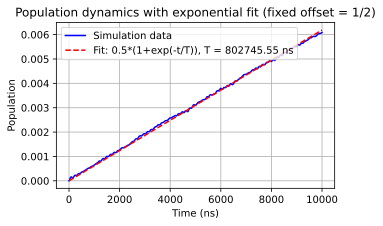

Fitted T = 802745.5451 ns
Estimated T = -828271.8738 ns
Analytical T2 = 1013553.1373 ns


In [35]:
T2_fit, T2_exact, T2_app = simulation.analyze_and_fit_decay(simulation, time_points, avg_values, S0)